# The quintic Ornstein-Uhlenbeck volatility model

This notebook is a complementary material of the paper "The quintic Ornstein-Uhlenbeck volatility model that jointly calibrates SPX \& VIX smiles" whose authors are Eduardo Abi Jaber, Camille Illand and Shaun LI. Here we show how to implement the model in practice for the pricing of SPX and VIX derivatives.

For further details we refer  the paper. **(!)** The code is far from being optimized. If you have any question on anything about the code (or the paper) don't hesitate to contact us ;)

## 1. The quintic Ornstein-Uhlenbeck model

  \begin{aligned}
    \frac{dS_t}{S_t} &= \sigma_tdB_t,\\
    \sigma_t &= \sqrt{\xi_0(t)}\frac{p(X_t)}{\sqrt{\mathbb E \left[p(X_t)^2\right]}}, \quad       p(x) =\alpha_0 + \alpha_1 x + \alpha_3 x^3 + \alpha_5 x^5,
\\
      X_t &= \varepsilon^{H-1/2} \int_0^t e^{-(1/2-H)\varepsilon^{-1}(t-s)} dW_s,
  \end{aligned}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.rcParams["figure.figsize"] = (4.8, 3.2)


import scipy
from scipy import interpolate
from math import exp, sqrt, log, pi

import warnings
warnings.filterwarnings('ignore') #to suppress warning messages

In [ ]:
pip install py_vollib

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for py_vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62832 sha256=b5c3ccfe7948b66882d617130f2c24ce40e9169f4472c3c80b136fcc3e35a805
  Stored in directory: /root/.cache/pip/wheels/c0/5c/8f/1ed590a10a2cca3cbfa7a7caa29fb5d729b3e1f819bfda4b5e
  Created wheel for py_lets_be_rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24450 sha256=25c2a0b869f9d5a77620d6b4376b5abc3be25e12d40344a78b57b84a8b7101f1
  Stored in directory: /root/.cache/pip/wheels/d9/20/b1/018f644bacb669d5cd6af600fe09ee0729ae5d75875a9f3043
Successfully built py_vollib py_lets_be_rational


In [ ]:
pip install scipy==1.8.1

ERROR: Ignored the following yanked versions: 1.11.0, 1.14.0rc1
ERROR: Ignored the following versions that require a different python version: 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11
ERROR: Could not find a version that satisfies the requirement scipy==1.8.1 (from versions: 0.8.0, 0.9.0, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.13.0, 0.13.1, 0.13.2, 0.13.3, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.16.0, 0.16.1, 0.17.0, 0.17.1, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 1.0.0, 1.0.1, 1.1.0, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.4.0, 1.4.1, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 1.5.4, 1.6.0, 1.6.1, 1.9.0rc1, 1.

In [ ]:
from py_vollib.black_scholes.implied_volatility import implied_volatility
vec_find_vol_rat = np.vectorize(implied_volatility)   #imp vol estimator based on P Jäckel Let's be rational

## 2. SPX call/put options by Monte Carlo with antithetic and control variates

In [ ]:
def horner_vector(poly, n, x):
    #Initialize result
    result = poly[0].reshape(-1,1)
    for i in range(1,n):
        result = result*x + poly[i].reshape(-1,1)
    return result

In [ ]:
def bs_price_call(s,sigma,T,K):
    #x is defined as St/K
    d1 = (np.log(s/K)+0.5*np.power(sigma,2.0)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    price = s*scipy.special.ndtr(d1)-K*scipy.special.ndtr(d2)
    return price

In [ ]:
def gen_bm_path(n_steps,N_sims):
    w1 = np.random.normal(0, 1, (n_steps, N_sims))
    #Antithetic variates
    w1 = np.concatenate((w1, -w1), axis = 1)
    return w1

In [ ]:
def doublefactorial(n):
    if n <= 0:
        return 1
    else:
        return n * doublefactorial(n - 2)

In [ ]:
def mc_polynomial_fwd_var(rho,H,eps,T,a_k_part,S0,strike_array,n_steps,N_sims,fv_nodes,T_array_nodes,w1,compute_iv = True):

    spine_k_order = 3

    eta_tild = eps**(H-0.5)
    kappa_tild = (0.5-H)/eps

    a_0,a_1,a_3,a_5 = a_k_part
    a_k = np.array([a_0,a_1,0,a_3,0,a_5])

    dt = T/n_steps
    tt = np.linspace(0., T, n_steps + 1)

    exp1 = np.exp(kappa_tild*tt)
    exp2 = np.exp(2*kappa_tild*tt)

    diff_exp2 = np.concatenate((np.array([0.]),np.diff(exp2)))
    std_vec = np.sqrt(diff_exp2/(2*kappa_tild))[:,np.newaxis] #to be broadcasted columnwise
    exp1 = exp1[:,np.newaxis]
    X = (1/exp1)*(eta_tild*np.cumsum(std_vec*w1, axis = 0))
    Xt = np.array(X[:-1])
    del X

    tt = tt[:-1]
    std_X_t = np.sqrt(eta_tild**2/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*tt)))
    n = len(a_k)

    cauchy_product = np.convolve(a_k,a_k)
    normal_var = np.sum(cauchy_product[np.arange(0,2*n,2)].reshape(-1,1)*std_X_t**(np.arange(0,2*n,2).reshape(-1,1))*\
        np.array([doublefactorial(z) for z in np.arange(0, 2 * n, 2) - 1]).reshape(-1,1),axis=0)


    f_func = horner_vector(a_k[::-1], len(a_k), Xt)

    del Xt

    fv_var_curve_spline_sqrt = interpolate.splrep(T_array_nodes, np.sqrt(fv_nodes),k=spine_k_order)
    fv_curve = (interpolate.splev(tt, fv_var_curve_spline_sqrt, der=0).reshape(-1,1))**2

    volatility = f_func/np.sqrt(normal_var.reshape(-1,1))
    del f_func
    volatility = np.sqrt(fv_curve)*volatility

    logS1 = log(S0)
    for i in range(w1.shape[0]-1):
        logS1 = logS1-0.5*dt*(volatility[i]*rho)**2+sqrt(dt)*rho*volatility[i]*w1[i+1]
    del w1
    ST1 = np.exp(logS1)
    del logS1

    int_var = np.sum(volatility[:-1,]**2*dt,axis=0)
    Q = np.max(int_var)+1e-9
    del volatility
    X = (bs_price_call(ST1,np.sqrt((1-rho**2)*int_var/T),T,strike_array.reshape(-1,1))).T
    Y = (bs_price_call(ST1,np.sqrt(rho**2*(Q-int_var)/T),T,strike_array.reshape(-1,1))).T
    del int_var
    eY = (bs_price_call(S0,np.sqrt(rho**2*(Q)/T),T,strike_array.reshape(-1,1))).T

    c = []
    for i in range(strike_array.shape[0]):
        cova = np.cov(X[:,i]+10,Y[:,i]+10)[0,1]
        varg = np.cov(X[:,i]+10,Y[:,i]+10)[1,1]
        if (cova or varg)<1e-8:
            temp = 1e-40
        else:
            temp = np.nan_to_num(cova/varg,1e-40)
        temp = np.minimum(temp,2)
        c.append(temp)
    c = np.array(c)

    call_mc_cv1 = X-c*(Y-eY)
    del X
    del Y
    del eY
    p_mc_cv1 = np.average(call_mc_cv1,axis=0)
    std_mc_cv1 = np.std(call_mc_cv1,axis=0)

    if compute_iv:
        flag = 'c'
        imp_mc = vec_find_vol_rat(p_mc_cv1, S0, strike_array, T, 0.0, flag)
        imp_mc_upper = vec_find_vol_rat(p_mc_cv1 + 1.96*std_mc_cv1/(np.sqrt(2*N_sims)), S0, strike_array, T, 0.0, flag)
        imp_mc_lower = vec_find_vol_rat(p_mc_cv1 - 1.96*std_mc_cv1/(np.sqrt(2*N_sims)), S0, strike_array, T, 0.0, flag)

        return p_mc_cv1, std_mc_cv1, imp_mc, imp_mc_upper, imp_mc_lower

    else:
        return p_mc_cv1,std_mc_cv1

In [ ]:
n_steps = 400
N_sims = 40000
np.random.seed(42)
w1_orig=gen_bm_path(n_steps,N_sims)
w1 = np.concatenate((np.zeros(w1_orig.shape[1])[np.newaxis,:],w1_orig))

In [ ]:
rho=-0.65
H = -0.1
eps = 1/52

In [ ]:
S0 = 100
T = 1/12
lm = np.linspace(-0.2,0.03,50)
#lm = np.linspace(-0.6,0.2,30)
#lm = np.linspace(-1,0.2,30)
strike_array = np.exp(lm)*S0
a_k_part = np.array([0.01,1,0.2,0.05])
a_k_part = [0.01,1,0.214, 0.227]
#a_k_part = np.array([0.00001,1,0,0])

In [ ]:
T_array_nodes = np.array([0,0.03,1/12,2/12,3/12,6/12,12/12,24/12])
fv_nodes = np.ones_like(T_array_nodes)*0.02   #fix fwd variance at 0.02
#fv_nodes = np.array([0.012,0.018,0.035,0.026,0.027,0.019,0.025,0.025])

In [ ]:
p_mc, std_mc, imp_mc, imp_mc_upper, imp_mc_lower = mc_polynomial_fwd_var(rho,H,eps,T,a_k_part,S0,strike_array,n_steps,N_sims,fv_nodes,T_array_nodes,w1)

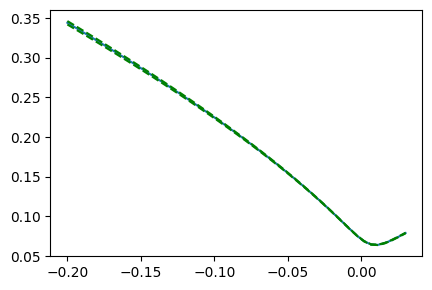

In [ ]:
flag = 'c'
plt.plot(lm,imp_mc)
plt.plot(lm,imp_mc_upper,'--g')
plt.plot(lm,imp_mc_lower,'--g')
plt.show()

## 3. VIX call/put options by Gaussian quadrature

In [ ]:
#gaussian quadrature
deg_vix = 800
x_org_vix, w_org_vix = np.polynomial.legendre.leggauss(deg_vix)
lb_vix = -8
ub_vix = 8

In [ ]:
#even faster computation of vix!
def gauss_dens(mu,sigma,x):
    return 1/np.sqrt(2*pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))
def vix_all_integration_poly_fast_revert_model(H,eps,T,a_k_part,x_org_vix,w_org_vix,vix_strike_perc,fv_nodes,T_array_nodes,n_steps = 200,compute_iv = True):
    spine_k_order = 3

    a2,a4 = (0,0)
    a0,a1,a3,a5 = a_k_part

    a_k = np.array([a0,a1,a2,a3,a4,a5])
    kappa_tild = (0.5-H)/eps
    eta_tild = eps**(H-0.5)

    delt = 30/360
    T_delta = T+delt

    w=w_org_vix/2*(ub_vix-lb_vix)
    y = (ub_vix-lb_vix)/2*x_org_vix + (ub_vix+lb_vix)/2
    std_X = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*T)))
    dt = delt/(n_steps)
    tt = np.linspace(T, T_delta, n_steps+1)

    exp_det = np.exp(-kappa_tild*(tt-T))
    cauchy_product = np.convolve(a_k,a_k)
    std_Gs_T = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*(tt-T))))
    std_X_t = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*tt)))
    std_X_T = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*T)))
    n = len(a_k)

    normal_var = np.sum(cauchy_product[np.arange(0,2*n,2)].reshape(-1,1)*std_X_t**(np.arange(0,2*n,2).reshape(-1,1))*\
    np.array([doublefactorial(z) for z in np.arange(0, 2 * n, 2) - 1]).reshape(-1,1),axis=0)

    fv_var_curve_spline_sqrt = interpolate.splrep(T_array_nodes, np.sqrt(fv_nodes),k=spine_k_order)
    FV_curve_all_vix = interpolate.splev(tt, fv_var_curve_spline_sqrt, der=0)**2

    beta = []
    for i in range(0,2*n-1):
        k_array = np.arange(i,2*n-1)
        beta_temp = ((std_Gs_T**((k_array-i).reshape(-1,1))*((k_array-i-1)%2).reshape(-1,1)*\
            np.array([doublefactorial(z) for z in k_array-i-1]).reshape(-1,1)*\
            (scipy.special.comb(k_array,i)).reshape(-1,1))*\
            exp_det**(i))*cauchy_product[k_array].reshape(-1,1)
        beta.append(np.sum(beta_temp,axis=0))
    beta = np.array(beta)*FV_curve_all_vix/normal_var

    beta = (np.sum((beta[:,:-1]+beta[:,1:])/2,axis=1))*dt
    vix_T = np.sqrt(horner_vector(beta[::-1], len(beta), std_X_T*y.reshape(1,-1))/delt)
    density = gauss_dens(0.0,1,y)
    Ft = np.sum(density*vix_T*w)
    vix_strike = Ft*vix_strike_perc
    option_prices = np.sum(density*np.maximum(vix_T-vix_strike.reshape(-1,1),0)*w,axis=1)

    if compute_iv:
        flag = 'c'
        imp_vol = vec_find_vol_rat(option_prices, Ft, vix_strike_perc*Ft, T, 0.0, flag)
        return Ft*100,option_prices*100,imp_vol
    else:
        return Ft*100,option_prices*100

In [ ]:
lm_vix = np.linspace(-0.1,1,50)
vix_strike_perc = np.exp(lm_vix)

In [ ]:
vix_fut,vix_call,vix_iv = vix_all_integration_poly_fast_revert_model(H,eps,T,a_k_part,x_org_vix,w_org_vix,vix_strike_perc,fv_nodes,T_array_nodes)

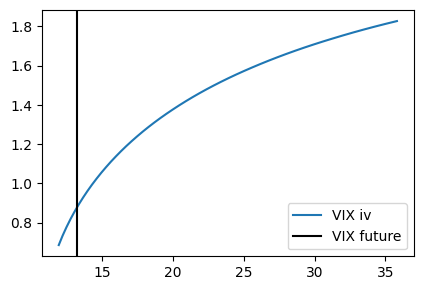

In [ ]:
plt.plot(vix_strike_perc*vix_fut, vix_iv, label = 'VIX iv')
plt.axvline(x = vix_fut, color = 'black', label = 'VIX future')
plt.legend()
plt.show()

## 4. Calibration results: based on the joint vol surface on 23/10/2017

In [ ]:
rho,H = -0.6842593 , -0.03583785
eps_fixed = 1/52
a_k_part = np.array([0.59069477,  0.99999991,  0.28927803, 0.05491437])
fvc = np.array([0.00950134,  0.00799541,  0.00514354,  0.01079057,
        0.02396814,  0.00793446,  0.01301627,  0.02776016,  0.00222057,
        0.01965447,  0.01085834,  0.02437202,  0.01278166,  0.01881186])
T_array_nodes = np.array([0, 0.02601012, 0.03696174, 0.05065128, 0.06297186,
       0.07529244, 0.08898198, 0.09993361, 0.10540942, 0.11636105,
       0.1355264 , 0.16427442, 0.21218779, 0.25736326])
St = 100

In [ ]:
spx_maturities = np.array([0.03011698, 0.08213721, 0.18343977, 0.24093582])
vix_maturities = np.array([0.02464116, 0.06297186, 0.08213721, 0.15879861])

In [ ]:
n_steps = 800
N_sims = 20000
np.random.seed(42)
w1_orig=gen_bm_path(n_steps,N_sims)
w1 = np.concatenate((np.zeros(w1_orig.shape[1])[np.newaxis,:],w1_orig))

In [ ]:
def spx_lm_range_rule(T_mat):
    if T_mat<2/52:
        lm_range = [-0.15,0.03]
    elif T_mat <1/12:
        lm_range = [-0.25,0.05]
    elif T_mat < 2/12:
        lm_range = [-0.4,0.1]
    elif T_mat < 3/12:
        lm_range = [-0.6,0.1]
    elif T_mat < 6/12:
        lm_range = [-0.7,0.15]
    else:
        lm_range = [-1,0.2]
    return lm_range

In [ ]:
spx_prices = []
spx_ivs = []
spx_ivs_u = []
spx_ivx_l = []
epochs_iter = tqdm(spx_maturities, desc="iteration", miniters=1)
for i in epochs_iter:
    lm_bd  = spx_lm_range_rule(i)
    strikes = np.exp(np.linspace(lm_bd[0],lm_bd[1],30))*St
    p_temp,_, iv_temp,iv_u_temp,iv_d_temp =  mc_polynomial_fwd_var(rho,H,eps_fixed,
                                    i,a_k_part,St,strikes,n_steps,N_sims,fvc,T_array_nodes,w1)
    spx_prices.append(p_temp)
    spx_ivs.append(iv_temp)
    spx_ivs_u.append(iv_u_temp)
    spx_ivx_l.append(iv_d_temp)

iteration:   0%|          | 0/4 [00:00<?, ?it/s]

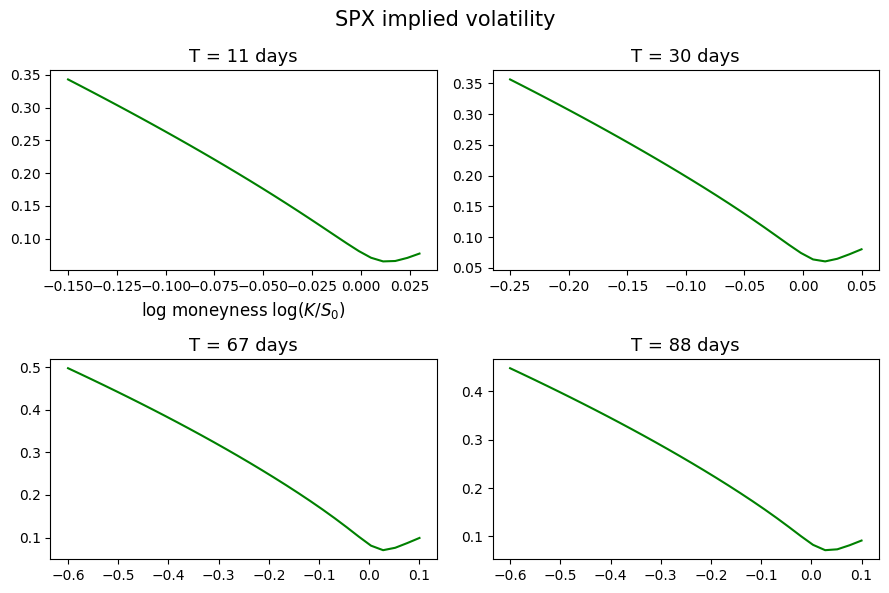

In [ ]:
plt.figure(1,figsize=(9,6))
counter=1
for i in spx_maturities:
    plt.subplot(2,2,counter)
    plt.suptitle('SPX implied volatility',fontsize=15)
    if counter ==1:
        plt.title('T = {} days'.format(int(np.round(i*365,0))),fontsize=13)

        lm_bd  = spx_lm_range_rule(i)
        lms = np.linspace(lm_bd[0],lm_bd[1],30)
        plt.plot(lms,spx_ivs[counter-1],'g')
        plt.xlabel("log moneyness $\log(K/S_0)$",fontsize=12)
    else:
        plt.title('T = {} days'.format(int(np.round(i*365,0))),fontsize=13)

        lm_bd  = spx_lm_range_rule(i)
        lms = np.linspace(lm_bd[0],lm_bd[1],30)
        plt.plot(lms,spx_ivs[counter-1],'g')

    counter+=1
plt.tight_layout()
plt.show()

In [ ]:
lm_vix = np.linspace(-0.1,1,50)
vix_strike_perc = np.exp(lm_vix)

In [ ]:
vix_futs = []
vix_opts = []
vix_ivs = []
epochs_iter = tqdm(vix_maturities, desc="iteration", miniters=1)
for i in epochs_iter:
    vix_fut_temp, vix_opt_temp, vix_iv_temp = vix_all_integration_poly_fast_revert_model(H,eps_fixed,
                                        i,a_k_part,x_org_vix,w_org_vix,vix_strike_perc,fvc,T_array_nodes)
    vix_futs.append(vix_fut_temp)
    vix_opts.append(vix_opt_temp)
    vix_ivs.append(vix_iv_temp)

iteration:   0%|          | 0/4 [00:00<?, ?it/s]

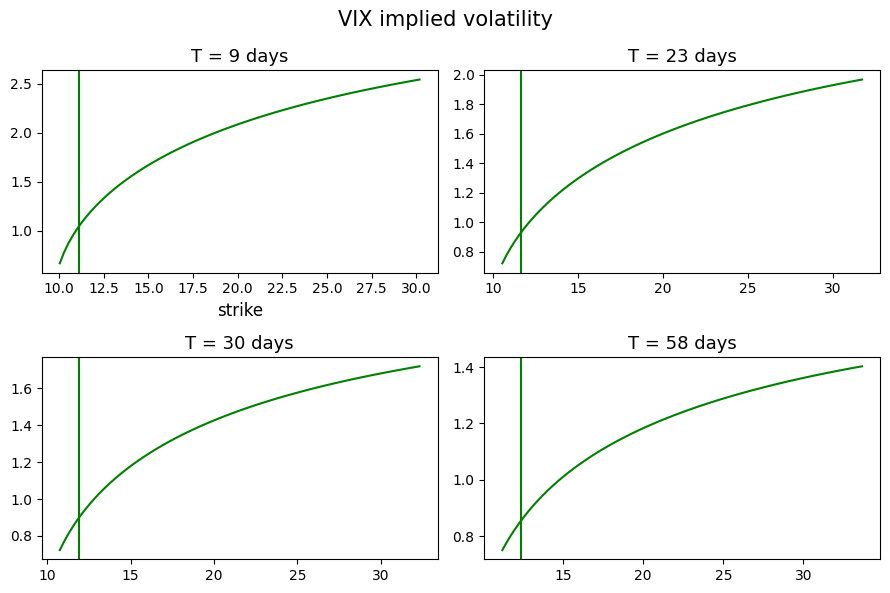

In [ ]:
plt.figure(1,figsize=(9,6))
counter=1
plt.suptitle('VIX implied volatility',fontsize=15)
for i in vix_maturities:
    plt.subplot(2,2,counter)
    plt.title('T = {} days'.format(int(np.round(i*365,0))),fontsize=13)

    plt.plot(vix_strike_perc*vix_futs[counter-1],vix_ivs[counter-1],'g', label = 'VIX iv')
    plt.axvline(x = vix_futs[counter-1], color = 'green', label = 'VIX future calibration')
    #plt.legend()
    if counter ==1:
        plt.xlabel("strike",fontsize=12)
    counter+=1
plt.tight_layout()
#plt.savefig('calibration_vix_time_dependent.pdf')
plt.show()

In [ ]:
t_grids = np.linspace(0,T_array_nodes[-1],20000)

In [ ]:
spine_k_order = 3
fv_var_graph = interpolate.splrep(T_array_nodes, np.sqrt(fvc),k=spine_k_order)
fv_var_graph = (interpolate.splev(t_grids, fv_var_graph, der=0).reshape(-1,1))**2

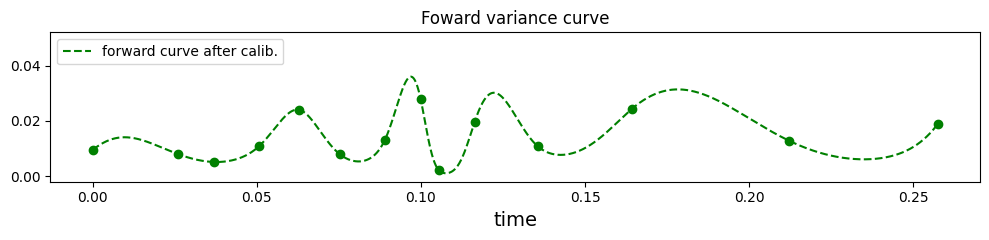

In [ ]:
#shows what the Forward var looks like between 0 to T
plt.figure(1,figsize=(10,2.5))
plt.title('Foward variance curve',y=1)
plt.plot(t_grids,fv_var_graph,'g--',label='forward curve after calib.')
plt.plot(T_array_nodes,fvc,'o',c='green')
plt.legend(loc='upper left')
plt.ylim(-0.002,0.052)
plt.xlabel("time",fontsize=14)
plt.tight_layout()
#plt.savefig('fwd_var_curve.pdf')
plt.show()

##5. Calibration results 2 slices SPX 1 slice VIX: based on the joint vol surface on 23/10/2017

Here we use a parametric forward variance curve defined as:
  \begin{aligned}
  \xi_0(t) = a e^{-b t} + c(1-e^{-b t})\\
  \end{aligned}
with $a,b,c >0$.

In [ ]:
def mc_polynomial_fwd_var_parametric(rho,H,eps,T,a_k_part,a,b,c,S0,strike_array,n_steps,N_sims,w1,compute_iv = True):

    spine_k_order = 3

    eta_tild = eps**(H-0.5)
    kappa_tild = (0.5-H)/eps

    a_0,a_1,a_3,a_5 = a_k_part
    a_k = np.array([a_0,a_1,0,a_3,0,a_5])

    dt = T/n_steps
    tt = np.linspace(0., T, n_steps + 1)

    exp1 = np.exp(kappa_tild*tt)
    exp2 = np.exp(2*kappa_tild*tt)

    diff_exp2 = np.concatenate((np.array([0.]),np.diff(exp2)))
    std_vec = np.sqrt(diff_exp2/(2*kappa_tild))[:,np.newaxis] #to be broadcasted columnwise
    exp1 = exp1[:,np.newaxis]
    X = (1/exp1)*(eta_tild*np.cumsum(std_vec*w1, axis = 0))
    Xt = np.array(X[:-1])
    del X

    tt = tt[:-1]
    std_X_t = np.sqrt(eta_tild**2/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*tt)))
    n = len(a_k)

    cauchy_product = np.convolve(a_k,a_k)
    normal_var = np.sum(cauchy_product[np.arange(0,2*n,2)].reshape(-1,1)*std_X_t**(np.arange(0,2*n,2).reshape(-1,1))*\
        np.array([doublefactorial(z) for z in np.arange(0,2*n,2)-1]).reshape(-1,1),axis=0)


    f_func = horner_vector(a_k[::-1], len(a_k), Xt)

    del Xt

    fv_curve = (a*np.exp(-b*tt)+c*(1-np.exp(-b*tt))).reshape(-1,1)

    volatility = f_func/np.sqrt(normal_var.reshape(-1,1))
    del f_func
    volatility = np.sqrt(fv_curve)*volatility

    logS1 = log(S0)
    for i in range(w1.shape[0]-1):
        logS1 = logS1-0.5*dt*(volatility[i]*rho)**2+sqrt(dt)*rho*volatility[i]*w1[i+1]
    del w1
    ST1 = np.exp(logS1)
    del logS1

    int_var = np.sum(volatility[:-1,]**2*dt,axis=0)
    Q = np.max(int_var)+1e-9
    del volatility
    X = (bs_price_call(ST1,np.sqrt((1-rho**2)*int_var/T),T,strike_array.reshape(-1,1))).T
    Y = (bs_price_call(ST1,np.sqrt(rho**2*(Q-int_var)/T),T,strike_array.reshape(-1,1))).T
    del int_var
    eY = (bs_price_call(S0,np.sqrt(rho**2*(Q)/T),T,strike_array.reshape(-1,1))).T

    c = []
    for i in range(strike_array.shape[0]):
        cova = np.cov(X[:,i]+10,Y[:,i]+10)[0,1]
        varg = np.cov(X[:,i]+10,Y[:,i]+10)[1,1]
        if (cova or varg)<1e-8:
            temp = 1e-40
        else:
            temp = np.nan_to_num(cova/varg,1e-40)
        temp = np.minimum(temp,2)
        c.append(temp)
    c = np.array(c)

    call_mc_cv1 = X-c*(Y-eY)
    del X
    del Y
    del eY
    p_mc_cv1 = np.average(call_mc_cv1,axis=0)
    std_mc_cv1 = np.std(call_mc_cv1,axis=0)

    if compute_iv:
        flag = 'c'
        imp_mc = vec_find_vol_rat(p_mc_cv1, S0, strike_array, T, 0.0, flag)
        imp_mc_upper = vec_find_vol_rat(p_mc_cv1 + 1.96*std_mc_cv1/(np.sqrt(2*N_sims)), S0, strike_array, T, 0.0, flag)
        imp_mc_lower = vec_find_vol_rat(p_mc_cv1 - 1.96*std_mc_cv1/(np.sqrt(2*N_sims)), S0, strike_array, T, 0.0, flag)

        return p_mc_cv1, std_mc_cv1, imp_mc, imp_mc_upper, imp_mc_lower

    else:
        return p_mc_cv1,std_mc_cv1

In [ ]:
def vix_all_integration_poly_fast_revert_model_parametric(H,eps,T,a_k_part,a,b,c,x_org_vix,w_org_vix,vix_strike_perc,n_steps = 200,compute_iv = True):
    spine_k_order = 3

    a2,a4 = (0,0)
    a0,a1,a3,a5 = a_k_part

    a_k = np.array([a0,a1,a2,a3,a4,a5])
    kappa_tild = (0.5-H)/eps
    eta_tild = eps**(H-0.5)

    delt = 30/360
    T_delta = T+delt

    w=w_org_vix/2*(ub_vix-lb_vix)
    y = (ub_vix-lb_vix)/2*x_org_vix + (ub_vix+lb_vix)/2
    std_X = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*T)))
    dt = delt/(n_steps)
    tt = np.linspace(T, T_delta, n_steps+1)

    FV_curve_all_vix = a*np.exp(-b*tt)+c*(1-np.exp(-b*tt))

    exp_det = np.exp(-kappa_tild*(tt-T))
    cauchy_product = np.convolve(a_k,a_k)
    std_Gs_T = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*(tt-T))))
    std_X_t = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*tt)))
    std_X_T = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*T)))
    n = len(a_k)

    normal_var = np.sum(cauchy_product[np.arange(0,2*n,2)].reshape(-1,1)*std_X_t**(np.arange(0,2*n,2).reshape(-1,1))*\
    np.array([doublefactorial(z) for z in np.arange(0,2*n,2)-1]).reshape(-1,1),axis=0)

    beta = []
    for i in range(0,2*n-1):
        k_array = np.arange(i,2*n-1)
        beta_temp = ((std_Gs_T**((k_array-i).reshape(-1,1))*((k_array-i-1)%2).reshape(-1,1)*\
            np.array([doublefactorial(z) for z in k_array-i-1]).reshape(-1,1)*\
            (scipy.special.comb(k_array,i)).reshape(-1,1))*\
            exp_det**(i))*cauchy_product[k_array].reshape(-1,1)
        beta.append(np.sum(beta_temp,axis=0))
    beta = np.array(beta)*FV_curve_all_vix/normal_var

    beta = (np.sum((beta[:,:-1]+beta[:,1:])/2,axis=1))*dt
    vix_T = np.sqrt(horner_vector(beta[::-1], len(beta), std_X_T*y.reshape(1,-1))/delt)
    density = gauss_dens(0.0,1,y)
    Ft = np.sum(density*vix_T*w)
    vix_strike = Ft*vix_strike_perc
    option_prices = np.sum(density*np.maximum(vix_T-vix_strike.reshape(-1,1),0)*w,axis=1)

    if compute_iv:
        flag = 'c'
        imp_vol = vec_find_vol_rat(option_prices, Ft, vix_strike_perc*Ft, T, 0.0, flag)
        return Ft*100,option_prices*100,imp_vol
    else:
        return Ft*100,option_prices*100

In [ ]:
rho,H = -0.73157011, -0.13815974
eps_fixed = 1/52
a_k_part = np.array([0.81685253,  0.27397169,  0.17173771,
        0.00360953])
a,b,c =  0.0084409 ,  2.04363437,  0.04406909
St = 100

In [ ]:
spx_maturities = np.array([0.02464116, 0.08213721])
vix_maturities = np.array([0.02464116])

In [ ]:
n_steps = 400
N_sims = 10000
np.random.seed(42)
w1_orig=gen_bm_path(n_steps,N_sims)
w1 = np.concatenate((np.zeros(w1_orig.shape[1])[np.newaxis,:],w1_orig))

In [ ]:
def spx_lm_range_rule(T_mat):
    if T_mat<2/52:
        lm_range = [-0.15,0.03]
    elif T_mat <1/12:
        lm_range = [-0.25,0.05]
    elif T_mat < 2/12:
        lm_range = [-0.4,0.1]
    elif T_mat < 3/12:
        lm_range = [-0.6,0.1]
    elif T_mat < 6/12:
        lm_range = [-0.7,0.15]
    else:
        lm_range = [-1,0.2]
    return lm_range

In [ ]:
spx_prices = []
spx_ivs = []
spx_ivs_u = []
spx_ivx_l = []
epochs_iter = tqdm(spx_maturities, desc="iteration", miniters=1)
for i in epochs_iter:
    lm_bd  = spx_lm_range_rule(i)
    strikes = np.exp(np.linspace(lm_bd[0],lm_bd[1],30))*St
    p_temp,_, iv_temp,iv_u_temp,iv_d_temp =  mc_polynomial_fwd_var_parametric(rho,H,eps_fixed,
                                    i,a_k_part,a,b,c,St,strikes,n_steps,N_sims,w1)
    spx_prices.append(p_temp)
    spx_ivs.append(iv_temp)
    spx_ivs_u.append(iv_u_temp)
    spx_ivx_l.append(iv_d_temp)

iteration:   0%|          | 0/2 [00:00<?, ?it/s]

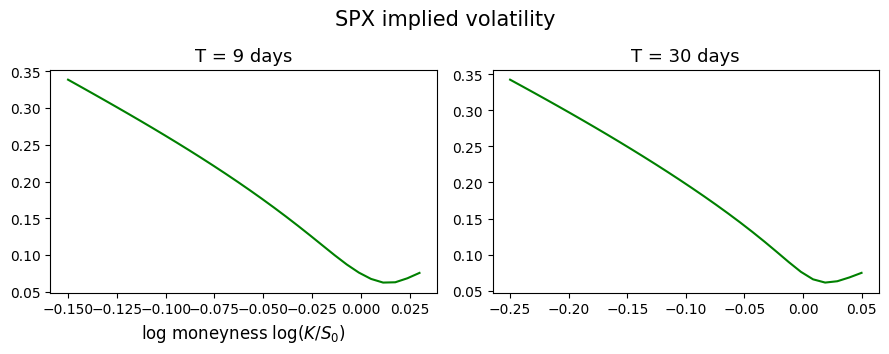

In [ ]:
plt.figure(1,figsize=(9,6))
counter=1
for i in spx_maturities:
    plt.subplot(2,2,counter)
    plt.suptitle('SPX implied volatility',fontsize=15)
    if counter ==1:
        plt.title('T = {} days'.format(int(np.round(i*365,0))),fontsize=13)

        lm_bd  = spx_lm_range_rule(i)
        lms = np.linspace(lm_bd[0],lm_bd[1],30)
        plt.plot(lms,spx_ivs[counter-1],'g')
        plt.xlabel("log moneyness $\log(K/S_0)$",fontsize=12)
    else:
        plt.title('T = {} days'.format(int(np.round(i*365,0))),fontsize=13)

        lm_bd  = spx_lm_range_rule(i)
        lms = np.linspace(lm_bd[0],lm_bd[1],30)
        plt.plot(lms,spx_ivs[counter-1],'g')

    counter+=1
plt.tight_layout()
plt.show()

In [ ]:
lm_vix = np.linspace(-0.1,1,50)
vix_strike_perc = np.exp(lm_vix)

In [ ]:
vix_futs = []
vix_opts = []
vix_ivs = []
epochs_iter = tqdm(vix_maturities, desc="iteration", miniters=1)
for i in epochs_iter:
    vix_fut_temp, vix_opt_temp, vix_iv_temp = vix_all_integration_poly_fast_revert_model_parametric(H,eps_fixed,
                                        i,a_k_part,a,b,c,x_org_vix,w_org_vix,vix_strike_perc)
    vix_futs.append(vix_fut_temp)
    vix_opts.append(vix_opt_temp)
    vix_ivs.append(vix_iv_temp)

iteration:   0%|          | 0/1 [00:00<?, ?it/s]

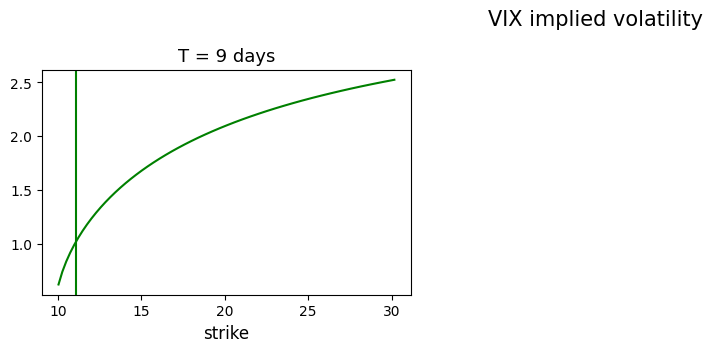

In [ ]:
plt.figure(1,figsize=(12,6))
counter=1
plt.suptitle('VIX implied volatility',fontsize=15)
for i in vix_maturities:
    plt.subplot(2,3,counter)
    plt.title('T = {} days'.format(int(np.round(i*365,0))),fontsize=13)

    plt.plot(vix_strike_perc*vix_futs[counter-1],vix_ivs[counter-1],'g', label = 'VIX iv')
    plt.axvline(x = vix_futs[counter-1], color = 'green', label = 'VIX future calibration')
    #plt.legend()
    if counter ==1:
        plt.xlabel("strike",fontsize=12)
    counter+=1
plt.tight_layout()
#plt.savefig('calibration_vix.pdf')
plt.show()

In [ ]:
rho,H = -0.7001,  0.141,
eps_fixed = 1/52
a_k_part = np.array([ 0.7558, 1, 0.0885, 0.4421,])
a,b,c = 0.012,  2.027,  0.033
St = 100

In [ ]:
spx_maturities = np.array([0.14510907, 0.24093582])
vix_maturities = np.array([0.15879861])

In [ ]:
def spx_lm_range_rule(T_mat):
    if T_mat<2/52:
        lm_range = [-0.15,0.03]
    elif T_mat <1/12:
        lm_range = [-0.25,0.05]
    elif T_mat < 2/12:
        lm_range = [-0.4,0.1]
    elif T_mat < 3/12:
        lm_range = [-0.6,0.1]
    elif T_mat < 6/12:
        lm_range = [-0.7,0.15]
    else:
        lm_range = [-1,0.2]
    return lm_range

In [ ]:
spx_prices = []
spx_ivs = []
spx_ivs_u = []
spx_ivx_l = []
epochs_iter = tqdm(spx_maturities, desc="iteration", miniters=1)
for i in epochs_iter:
    lm_bd  = spx_lm_range_rule(i)
    strikes = np.exp(np.linspace(lm_bd[0],lm_bd[1],30))*St
    p_temp,_, iv_temp,iv_u_temp,iv_d_temp =  mc_polynomial_fwd_var_parametric(rho,H,eps_fixed,
                                    i,a_k_part,a,b,c,St,strikes,n_steps,N_sims,w1)
    spx_prices.append(p_temp)
    spx_ivs.append(iv_temp)
    spx_ivs_u.append(iv_u_temp)
    spx_ivx_l.append(iv_d_temp)

iteration:   0%|          | 0/2 [00:00<?, ?it/s]

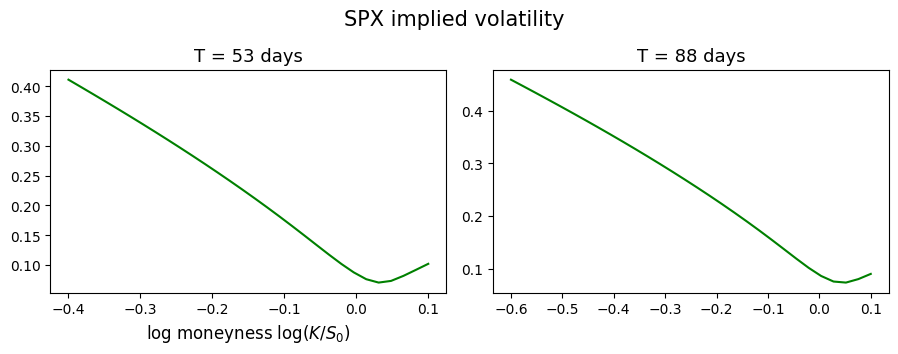

In [ ]:
plt.figure(1,figsize=(9,6))
counter=1
for i in spx_maturities:
    plt.subplot(2,2,counter)
    plt.suptitle('SPX implied volatility',fontsize=15)
    if counter ==1:
        plt.title('T = {} days'.format(int(np.round(i*365,0))),fontsize=13)

        lm_bd  = spx_lm_range_rule(i)
        lms = np.linspace(lm_bd[0],lm_bd[1],30)
        plt.plot(lms,spx_ivs[counter-1],'g')
        plt.xlabel("log moneyness $\log(K/S_0)$",fontsize=12)
    else:
        plt.title('T = {} days'.format(int(np.round(i*365,0))),fontsize=13)

        lm_bd  = spx_lm_range_rule(i)
        lms = np.linspace(lm_bd[0],lm_bd[1],30)
        plt.plot(lms,spx_ivs[counter-1],'g')

    counter+=1
plt.tight_layout()
plt.show()

In [ ]:
lm_vix = np.linspace(-0.1,1.3,50)
vix_strike_perc = np.exp(lm_vix)

In [ ]:
vix_futs = []
vix_opts = []
vix_ivs = []
epochs_iter = tqdm(vix_maturities, desc="iteration", miniters=1)
for i in epochs_iter:
    vix_fut_temp, vix_opt_temp, vix_iv_temp = vix_all_integration_poly_fast_revert_model_parametric(H,eps_fixed,
                                        i,a_k_part,a,b,c,x_org_vix,w_org_vix,vix_strike_perc)
    vix_futs.append(vix_fut_temp)
    vix_opts.append(vix_opt_temp)
    vix_ivs.append(vix_iv_temp)

iteration:   0%|          | 0/1 [00:00<?, ?it/s]

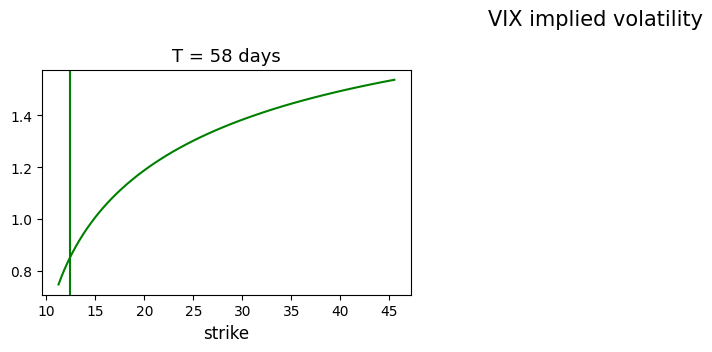

In [ ]:
plt.figure(1,figsize=(12,6))
counter=1
plt.suptitle('VIX implied volatility',fontsize=15)
for i in vix_maturities:
    plt.subplot(2,3,counter)
    plt.title('T = {} days'.format(int(np.round(i*365,0))),fontsize=13)

    plt.plot(vix_strike_perc*vix_futs[counter-1],vix_ivs[counter-1],'g', label = 'VIX iv')
    plt.axvline(x = vix_futs[counter-1], color = 'green', label = 'VIX future calibration')
    #plt.legend()
    if counter ==1:
        plt.xlabel("strike",fontsize=12)
    counter+=1
plt.tight_layout()
#plt.savefig('calibration_vix.pdf')
plt.show()

#6. The time dependent quintic Ornstein-Uhlenbeck volatility model

Here we make H time dependent as:
  \begin{aligned}
  H(t) = H_0e^{-\kappa t} + H_{∞}(1-e^{-\kappa t})\\
  \end{aligned}
with $H_0,H_{∞},\kappa>0$. $X$ remains a Markovian OU process with time dependent vol of vol and mean reversion characterized by $H(t)$

In [ ]:
#used to estimate integral of type \int_0^T f(t)e^{g(t)}dt with f(t) and g(t) derived from time dependent H parametrization
x_org_h, w_org_h = np.polynomial.legendre.leggauss(100)

In [ ]:
def mc_polynomial_fwd_var_time_dependent_H(rho,H_0,H_inf,H_mr,eps,T,a_k_part,S0,strike_array,n_steps,N_sims,fv_nodes,T_array_nodes,w1,compute_iv = True):

    spine_k_order = 3

    a2,a4 = (0,0)
    a0,a1,a3,a5 = a_k_part
    a_k = np.array([a0,a1,a2,a3,a4,a5])

    dt = T/n_steps
    tt = np.linspace(0., T, n_steps + 1)


    exp1 = np.exp(1/(2*eps)*tt-1/eps*(H_0/H_mr*(1-np.exp(-H_mr*tt))+H_inf*tt-H_inf/H_mr*(1-np.exp(-H_mr*tt))))
    tt_diff = 0.5*(x_org_h + 1)*(tt[1:]-tt[:-1]).reshape(-1,1)+tt[:-1].reshape(-1,1)   #gaussian qaudrature nodes
    w_diff = w_org_h/2*(tt[1:]-tt[:-1]).reshape(-1,1)    #gaussian quadrature weights
    kappa_tild_diff = 1/(2*eps)*tt_diff-1/eps*(H_0/H_mr*(1-np.exp(-H_mr*tt_diff))+\
                            H_inf*tt_diff-H_inf/H_mr*(1-np.exp(-H_mr*tt_diff)))
    H_diff = H_0*np.exp(-H_mr*tt_diff)+H_inf*(1-np.exp(-H_mr*tt_diff))
    eta_tild_diff = eps**(H_diff-0.5)

    var_diff = np.sum(eta_tild_diff**2*np.exp(2*kappa_tild_diff)*w_diff,axis=1)
    var_diff = np.concatenate((np.array([0.]),var_diff))
    std_vec_diff = np.sqrt(var_diff)[:,np.newaxis] #to be broadcasted columnwise
    std_X_t = np.sqrt(np.cumsum(var_diff))/exp1

    Xt = (1/exp1[:,np.newaxis])*(np.cumsum(std_vec_diff*w1, axis = 0))
    Xt = np.array(Xt[:-1])

    tt = tt[:-1]
    std_X_t = std_X_t[:-1]

    n = len(a_k)

    cauchy_product = np.convolve(a_k,a_k)
    normal_var = np.sum(cauchy_product[np.arange(0,2*n,2)].reshape(-1,1)*std_X_t**(np.arange(0,2*n,2).reshape(-1,1))*\
        np.array([doublefactorial(z) for z in np.arange(0,2*n,2)-1]).reshape(-1,1),axis=0)

    f_func = horner_vector(a_k[::-1], len(a_k), Xt)

    del Xt

    fv_var_curve_spline_sqrt = interpolate.splrep(T_array_nodes, np.sqrt(fv_nodes),k=spine_k_order)
    fv_curve = (interpolate.splev(tt, fv_var_curve_spline_sqrt, der=0).reshape(-1,1))**2

    volatility = f_func/np.sqrt(normal_var.reshape(-1,1))
    del f_func
    volatility = np.sqrt(fv_curve)*volatility

    logS1 = log(S0)
    for i in range(w1.shape[0]-1):
        logS1 = logS1-0.5*dt*(volatility[i]*rho)**2+sqrt(dt)*rho*volatility[i]*w1[i+1]
    del w1
    ST1 = np.exp(logS1)
    del logS1

    int_var = np.sum(volatility[:-1,]**2*dt,axis=0)
    Q = np.max(int_var)+1e-9
    del volatility
    X = (bs_price_call(ST1,np.sqrt((1-rho**2)*int_var/T),T,strike_array.reshape(-1,1))).T
    Y = (bs_price_call(ST1,np.sqrt(rho**2*(Q-int_var)/T),T,strike_array.reshape(-1,1))).T
    del int_var
    eY = (bs_price_call(S0,np.sqrt(rho**2*(Q)/T),T,strike_array.reshape(-1,1))).T

    c = []
    for i in range(strike_array.shape[0]):
        cova = np.cov(X[:,i]+10,Y[:,i]+10)[0,1]
        varg = np.cov(X[:,i]+10,Y[:,i]+10)[1,1]
        if (cova or varg)<1e-8:
            temp = 1e-40
        else:
            temp = np.nan_to_num(cova/varg,1e-40)
        temp = np.minimum(temp,2)
        c.append(temp)
    c = np.array(c)

    call_mc_cv1 = X-c*(Y-eY)
    del X
    del Y
    del eY
    p_mc_cv1 = np.average(call_mc_cv1,axis=0)
    std_mc_cv1 = np.std(call_mc_cv1,axis=0)

    if compute_iv:
        flag = 'c'
        imp_mc = vec_find_vol_rat(p_mc_cv1, S0, strike_array, T, 0.0, flag)
        imp_mc_upper = vec_find_vol_rat(p_mc_cv1 + 1.96*std_mc_cv1/(np.sqrt(2*N_sims)), S0, strike_array, T, 0.0, flag)
        imp_mc_lower = vec_find_vol_rat(p_mc_cv1 - 1.96*std_mc_cv1/(np.sqrt(2*N_sims)), S0, strike_array, T, 0.0, flag)

        return p_mc_cv1, std_mc_cv1, imp_mc, imp_mc_upper, imp_mc_lower

    else:
        return p_mc_cv1,std_mc_cv1

In [ ]:
n_steps = 200
N_sims = 10000
np.random.seed(42)
w1_orig=gen_bm_path(n_steps,N_sims)
w1 = np.concatenate((np.zeros(w1_orig.shape[1])[np.newaxis,:],w1_orig))

In [ ]:
rho=-0.6997
eps = 1/52
H_0 = -0.26939
H_inf = 0.3
H_mr = 4

In [ ]:
S0 = 100
T = 1/12
lm = np.linspace(-0.2,0.05,30)
#lm = np.linspace(-0.6,0.2,30)
#lm = np.linspace(-1,0.2,30)
strike_array = np.exp(lm)*S0
a_k_part = np.array([0.01,1,0.2,0.05])
a_k_part = [0.82695, 0.84388, 0.55012, 0.03271]
#a_k_part = np.array([0.00001,1,0,0])

In [ ]:
T_array_nodes = np.array([0,0.03,1/12,2/12,3/12,6/12,12/12,24/12])
fv_nodes = np.ones_like(T_array_nodes)*0.03   #fix fwd variance at 0.02
#fv_nodes = np.array([0.012,0.018,0.035,0.026,0.027,0.019,0.025,0.025])

In [ ]:
p_mc_H, std_mc_H, imp_mc_H, imp_mc_upper_H, imp_mc_lower_H = mc_polynomial_fwd_var_time_dependent_H(rho,H_0,H_inf,H_mr,eps,T,a_k_part,S0,strike_array,n_steps,N_sims,fv_nodes,T_array_nodes,w1)

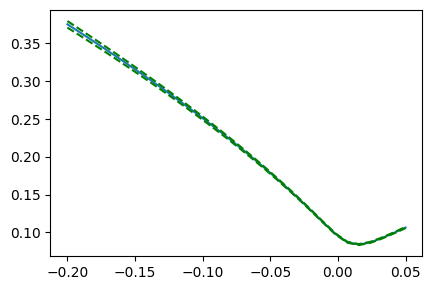

In [ ]:
plt.plot(lm,imp_mc_H)
plt.plot(lm,imp_mc_upper_H,'--g')
plt.plot(lm,imp_mc_lower_H,'--g')
plt.show()

In [ ]:
#gaussian quadrature
deg_vix = 400
x_org_vix, w_org_vix = np.polynomial.legendre.leggauss(deg_vix)
lb_vix = -8
ub_vix = 8

In [ ]:
#even faster computation of vix!
def gauss_dens(mu,sigma,x):
    return 1/np.sqrt(2*pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))
def vix_all_integration_poly_fast_revert_model_H_time_dependent(H_0,H_inf,H_mr,eps,T,a_k_part,x_org_vix,w_org_vix,vix_strike_perc,fv_nodes,T_array_nodes,n_steps = 200,compute_iv = True):
    spine_k_order = 3

    a2,a4 = (0,0)
    a0,a1,a3,a5 = a_k_part
    a_k = np.array([a0,a1,a2,a3,a4,a5])
    delt = 30/360
    T_delta = T+delt

    w=w_org_vix/2*(ub_vix-lb_vix)
    y = (ub_vix-lb_vix)/2*x_org_vix + (ub_vix+lb_vix)/2
    dt = delt/(n_steps)
    tt = np.linspace(T, T_delta, n_steps+1)

    kappa_tild_XT_std = 1/(2*eps)*T-1/eps*(H_0/H_mr*(1-np.exp(-H_mr*T))+\
                            H_inf*T-H_inf/H_mr*(1-np.exp(-H_mr*T)))
    kappa_tild_det = 1/(2*eps)*tt-1/eps*(H_0/H_mr*(1-np.exp(-H_mr*tt))+\
                            H_inf*tt-H_inf/H_mr*(1-np.exp(-H_mr*tt)))
    exp_det = np.exp((-kappa_tild_det+kappa_tild_XT_std))

    w_ttt =w_org_h/2*tt.reshape(-1,1)
    ttt = 0.5*(x_org_h + 1)*tt.reshape(-1,1)
    kappa_tild_Xuu_std = 1/(2*eps)*ttt-1/eps*(H_0/H_mr*(1-np.exp(-H_mr*ttt))+\
                            H_inf*ttt-H_inf/H_mr*(1-np.exp(-H_mr*ttt)))
    H_Xuu_std = H_0*np.exp(-H_mr*ttt)+H_inf*(1-np.exp(-H_mr*ttt))
    eta_tild_Xuu_std = eps**(H_Xuu_std-0.5)
    kappa_tild_Xu_std = 1/(2*eps)*tt-1/eps*(H_0/H_mr*(1-np.exp(-H_mr*tt))+\
                            H_inf*tt-H_inf/H_mr*(1-np.exp(-H_mr*tt)))
    std_X_u = np.sqrt(np.exp(-2*kappa_tild_Xu_std)*np.sum(np.exp(2*kappa_tild_Xuu_std)*eta_tild_Xuu_std**2*w_ttt,axis=1))
    std_X_T = std_X_u[0]

    tt_diff = 0.5*(x_org_h + 1)*(tt-T).reshape(-1,1)+T
    w_diff = w_org_h/2*(tt-T).reshape(-1,1)
    kappa_tild_diff = 1/(2*eps)*tt_diff-1/eps*(H_0/H_mr*(1-np.exp(-H_mr*tt_diff))+\
                            H_inf*tt_diff-H_inf/H_mr*(1-np.exp(-H_mr*tt_diff)))
    H_diff = H_0*np.exp(-H_mr*tt_diff)+H_inf*(1-np.exp(-H_mr*tt_diff))
    eta_tild_diff = eps**(H_diff-0.5)
    std_Gs_T = np.sum((np.exp(2*kappa_tild_diff)*eta_tild_diff**2)*w_diff,axis=1)
    std_Gs_T = np.sqrt(np.exp(-2*kappa_tild_Xu_std)*std_Gs_T)

    cauchy_product = np.convolve(a_k,a_k)
    n = len(a_k)

    normal_var = np.sum(cauchy_product[np.arange(0,2*n,2)].reshape(-1,1)*std_X_u**(np.arange(0,2*n,2).reshape(-1,1))*\
    np.array([doublefactorial(z) for z in np.arange(0,2*n,2)-1]).reshape(-1,1),axis=0)

    fv_var_curve_spline_sqrt = interpolate.splrep(T_array_nodes, np.sqrt(fv_nodes),k=spine_k_order)
    FV_curve_all_vix = interpolate.splev(tt, fv_var_curve_spline_sqrt, der=0)**2

    beta = []
    for i in range(0,2*n-1):
        k_array = np.arange(i,2*n-1)
        beta_temp = ((std_Gs_T**((k_array-i).reshape(-1,1))*((k_array-i-1)%2).reshape(-1,1)*\
            np.array([doublefactorial(z) for z in k_array-i-1]).reshape(-1,1)*\
            (scipy.special.comb(k_array,i)).reshape(-1,1))*\
            exp_det**(i))*cauchy_product[k_array].reshape(-1,1)
        beta.append(np.sum(beta_temp,axis=0))
    beta = np.array(beta)*FV_curve_all_vix/normal_var

    beta = (np.sum((beta[:,:-1]+beta[:,1:])/2,axis=1))*dt
    vix_T = np.sqrt(horner_vector(beta[::-1], len(beta), std_X_T*y.reshape(1,-1))/delt)
    density = gauss_dens(0.0,1,y)
    Ft = np.sum(density*vix_T*w)
    vix_strike = Ft*vix_strike_perc
    option_prices = np.sum(density*np.maximum(vix_T-vix_strike.reshape(-1,1),0)*w,axis=1)

    if compute_iv:
        flag = 'c'
        imp_vol = vec_find_vol_rat(option_prices, Ft, vix_strike_perc*Ft, T, 0.0, flag)
        return Ft*100,option_prices*100,imp_vol
    else:
        return Ft*100,option_prices*100

In [ ]:
lm_vix = np.linspace(-0.1,1,50)
vix_strike_perc = np.exp(lm_vix)

In [ ]:
vix_fut_H,vix_call_H,vix_iv_H = vix_all_integration_poly_fast_revert_model_H_time_dependent(H_0,H_inf, H_mr,eps,T,a_k_part,x_org_vix,w_org_vix,vix_strike_perc,fv_nodes,T_array_nodes)

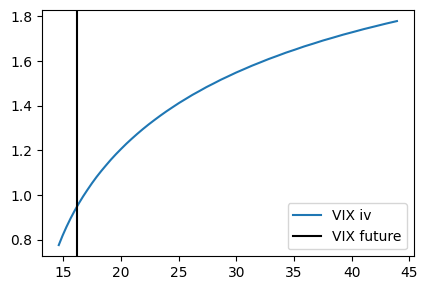

In [ ]:
plt.plot(vix_strike_perc*vix_fut_H, vix_iv_H, label = 'VIX iv')
plt.axvline(x = vix_fut_H, color = 'black', label = 'VIX future')
plt.legend()
plt.show()

#7. Calibration results: based on the joint vol surface on 23/10/2017

In [ ]:
rho,H_0, H_inf, H_mr,eps = (-7.46560529e-01,  3.17620635e-01, -1.36650102e+00,  1.19935418e+01,
        1.35941796e-01)
a_k_part = np.array([1.00000000e-10,  2.66441061e-02,  2.51336785e-01,
        5.87934269e-05])
fvc = np.array([0.01031423, 0.01107315, 0.01234894, 0.01404261, 0.01595505,
       0.01783993, 0.02130452, 0.02413495, 0.02455308, 0.02683603,
       0.02818511, 0.03133947, 0.03852319, 0.03261153, 0.03186])
T_array_nodes = np.array([0., 0.03285488, 0.05612709, 0.08761302, 0.12594372,
       0.19302244, 0.25736326, 0.29569396, 0.33402465, 0.37235535,
       0.412055  , 0.53662977, 0.77756559, 1.0362978 , 1.16      ])
St = 100

In [ ]:
spx_maturities = np.array([0.03011698, 0.08213721, 0.18343977, 0.24093582, 0.68173884,
       1.16087257])
vix_maturities = np.array([0.02464116, 0.08213721, 0.15879861, 0.23546   , 0.3121214 ,
       0.40794814])

In [ ]:
n_steps = 400
N_sims = 10000
np.random.seed(42)
w1_orig=gen_bm_path(n_steps,N_sims)
w1 = np.concatenate((np.zeros(w1_orig.shape[1])[np.newaxis,:],w1_orig))

In [ ]:
def spx_lm_range_rule(T_mat):
    if T_mat<2/52:
        lm_range = [-0.15,0.03]
    elif T_mat <1/12:
        lm_range = [-0.25,0.05]
    elif T_mat < 2/12:
        lm_range = [-0.4,0.1]
    elif T_mat < 3/12:
        lm_range = [-0.6,0.1]
    elif T_mat < 6/12:
        lm_range = [-0.7,0.15]
    else:
        lm_range = [-1,0.2]
    return lm_range

In [ ]:
spx_prices = []
spx_ivs = []
spx_ivs_u = []
spx_ivx_l = []
epochs_iter = tqdm(spx_maturities, desc="iteration", miniters=1)
for i in epochs_iter:
    lm_bd  = spx_lm_range_rule(i)
    strikes = np.exp(np.linspace(lm_bd[0],lm_bd[1],30))*St
    p_temp,_, iv_temp,iv_u_temp,iv_d_temp =  mc_polynomial_fwd_var_time_dependent_H(rho,H_0,H_inf,H_mr,eps,
                                    i,a_k_part,St,strikes,n_steps,N_sims,fvc,T_array_nodes,w1)
    spx_prices.append(p_temp)
    spx_ivs.append(iv_temp)
    spx_ivs_u.append(iv_u_temp)
    spx_ivx_l.append(iv_d_temp)

iteration:   0%|          | 0/6 [00:00<?, ?it/s]

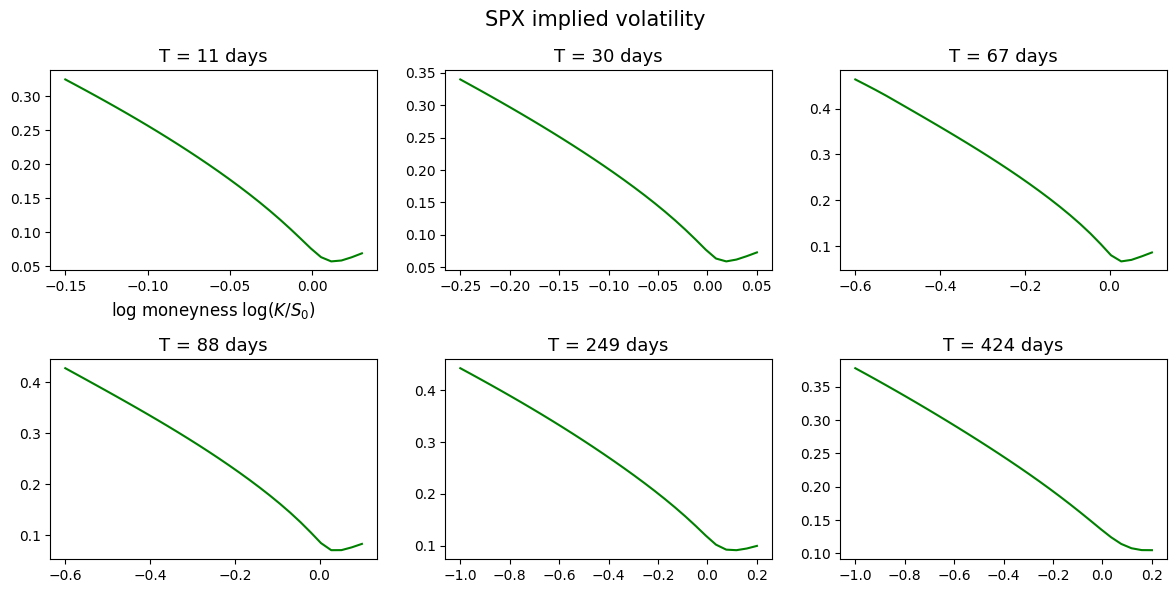

In [ ]:
plt.figure(1,figsize=(12,6))
counter=1
for i in spx_maturities:
    plt.subplot(2,3,counter)
    plt.suptitle('SPX implied volatility',fontsize=15)
    if counter ==1:
        plt.title('T = {} days'.format(int(np.round(i*365,0))),fontsize=13)

        lm_bd  = spx_lm_range_rule(i)
        lms = np.linspace(lm_bd[0],lm_bd[1],30)
        plt.plot(lms,spx_ivs[counter-1],'g')
        plt.xlabel("log moneyness $\log(K/S_0)$",fontsize=12)
    else:
        plt.title('T = {} days'.format(int(np.round(i*365,0))),fontsize=13)

        lm_bd  = spx_lm_range_rule(i)
        lms = np.linspace(lm_bd[0],lm_bd[1],30)
        plt.plot(lms,spx_ivs[counter-1],'g')

    counter+=1
plt.tight_layout()
plt.show()

In [ ]:
lm_vix = np.linspace(-0.1,1,50)
vix_strike_perc = np.exp(lm_vix)

In [ ]:
vix_futs = []
vix_opts = []
vix_ivs = []
epochs_iter = tqdm(vix_maturities, desc="iteration", miniters=1)
for i in epochs_iter:
    vix_fut_temp, vix_opt_temp, vix_iv_temp = vix_all_integration_poly_fast_revert_model_H_time_dependent(H_0,H_inf,H_mr,eps,
                                        i,a_k_part,x_org_vix,w_org_vix,vix_strike_perc,fvc,T_array_nodes)
    vix_futs.append(vix_fut_temp)
    vix_opts.append(vix_opt_temp)
    vix_ivs.append(vix_iv_temp)

iteration:   0%|          | 0/6 [00:00<?, ?it/s]

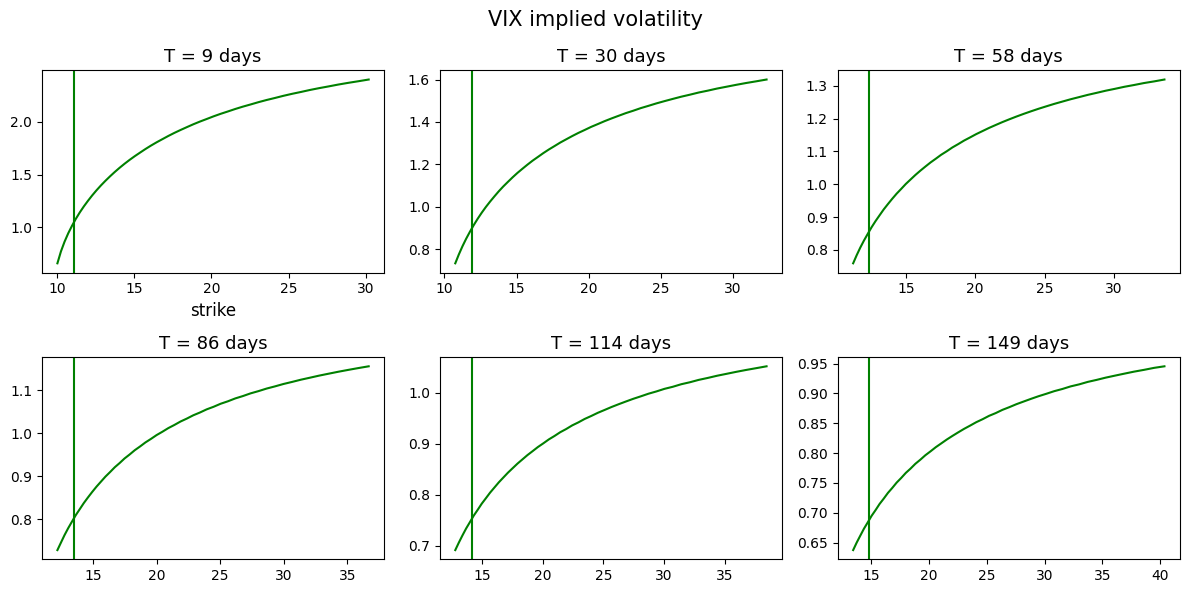

In [ ]:
plt.figure(1,figsize=(12,6))
counter=1
plt.suptitle('VIX implied volatility',fontsize=15)
for i in vix_maturities:
    plt.subplot(2,3,counter)
    plt.title('T = {} days'.format(int(np.round(i*365,0))),fontsize=13)

    plt.plot(vix_strike_perc*vix_futs[counter-1],vix_ivs[counter-1],'g', label = 'VIX iv')
    plt.axvline(x = vix_futs[counter-1], color = 'green', label = 'VIX future calibration')
    #plt.legend()
    if counter ==1:
        plt.xlabel("strike",fontsize=12)
    counter+=1
plt.tight_layout()
#plt.savefig('calibration_vix_time_dependent.pdf')
plt.show()

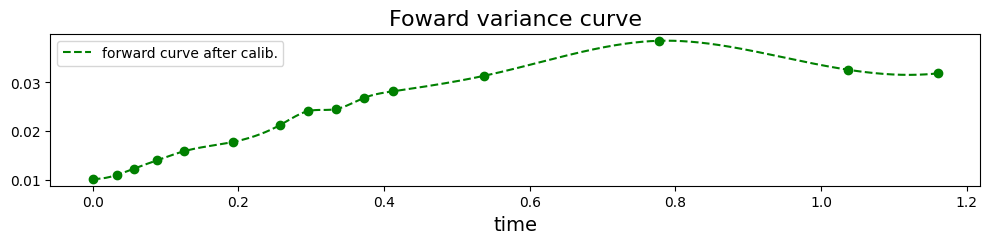

In [ ]:
t_grids = np.linspace(0,T_array_nodes[-1],20000)
spine_k_order = 3
fv_var_graph = interpolate.splrep(T_array_nodes, np.sqrt(fvc),k=spine_k_order)
fv_var_graph = (interpolate.splev(t_grids, fv_var_graph, der=0).reshape(-1,1))**2
#shows what the Forward var \xi_0(t) looks like between 0 to T
plt.figure(1,figsize=(10,2.3))
plt.title('Foward variance curve',y=1,fontsize=16)
plt.plot(t_grids,fv_var_graph,'g--',label='forward curve after calib.')
plt.plot(T_array_nodes,fvc,'o',c='green')
plt.legend(loc='upper left')
plt.tight_layout()
plt.xlabel("time",fontsize=14)
#plt.savefig('fwd_var_curve_time_dependent.pdf')
plt.show()

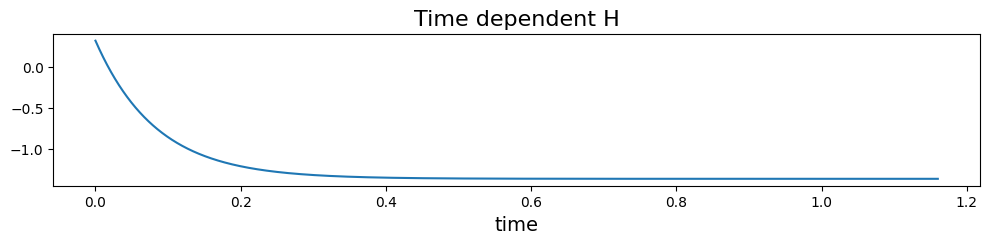

In [ ]:
plt.figure(1,figsize=(10,2.3))
plt.title('Time dependent H',y=1,fontsize=16)
plt.plot(t_grids,H_0*np.exp(-H_mr*t_grids)+H_inf*(1-np.exp(-H_mr*t_grids)))
plt.tight_layout()
plt.xlabel("time",fontsize=14)
#plt.savefig('time_dependent_H.pdf')
plt.show()